<a href="https://colab.research.google.com/github/pablex72/vi-phenology-analysis-/blob/main/FINAL_LSTM_GRU_XGBoost_Random_Forest_SVM_mm22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM

**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from keras.optimizers import Adam
df = pd.read_csv('/content/sg_smoothed_ndvi_farm1.csv')

dfDate = df[['Date']]  #index, date (dataframe)

#making date column into index column
df.index = df.pop('Date') #date, ndvi (no index) (dataframe)

testDf = df
df = df.values # ndvi (array)

dfDate=dfDate.values
#dfDate = np.array(dfDate)
dfDate = dfDate.flatten() # date ()
#############################################################################33    FEATURE LENGTH
feature_length = 1
#Splitting
def Create_Features_and_Targets(data, dates, feature_length):
  X = list()
  Y = list()
  datesF = list()
  for i in range(len(data) - feature_length - 1):
    X.append(data[i:(i + feature_length), :])
    Y.append(data[i + feature_length, -1])
  X = np.array(X)
  Y = np.array(Y)
  datesF = np.array(dates[feature_length+1:])
  return datesF, X, Y

dates, X, y = Create_Features_and_Targets(df,dfDate, feature_length)

q_80 = int(len(dates) * .8)
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_test, X_test, y_test = dates[q_80:], X[q_80:], y[q_80:]

adam = Adam(lr=0.001)

model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(16, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(1, activation='sigmoid'),
])
model.compile(optimizer=adam, loss="mean_squared_error")
model.summary()

history = model.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 12,
    verbose = 0,
)

y_pred = model.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Calculate predicted values
y_pred_lstm = model.predict(X_test)
# Calculate evaluation metrics
r2_lstm = r2_score(y_test, y_pred_lstm)
rmse = mean_squared_error(y_test, y_pred_lstm, squared=False)
mse = mean_squared_error(y_test, y_pred_lstm, squared=True)
mae = mean_absolute_error(y_test, y_pred_lstm)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 32)             4352      
                                                                 
 dropout (Dropout)           (None, 1, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 16)             3136      
                                                                 
 dropout_1 (Dropout)         (None, 1, 16)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                6272      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 13793 (53.88 KB)
Trainable params: 13793 (

#svm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


df = pd.read_csv('/content/sg_smoothed_ndvi_farm1.csv')
df

# Build the target, the next NDVI value
df['Target'] = df['NDVI'].shift(-1) # Target NDVI will be the next Sample
target_df = df[:-1]
target_df

# Creating Feature and Target with X and y respectively
X = target_df[['NDVI', 'Target']].values[:,:1]
y = target_df[['NDVI', 'Target']].values[:,1:]

X.shape, y.shape
#((124, 1), (124, 1))


# Spliting the data into train(80%) and test(20%) parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)
# Splitting the dates
train_dates = target_df.Date[:int(len(X)*0.80)]
test_dates =  target_df.Date[int(len(X)*0.80):]


X_train.shape, X_test.shape, y_train.shape, y_test.shape

regressor = SVR(kernel='rbf', C=1.0, epsilon=0.1) #0.7760--0.9433
#regressor = SVR(kernel='rbf', C=1.0, epsilon=0.02) #0.7760

#regressor_rbf = SVR(kernel='rbf', C=1.0, epsilon=0.1) #0.46

# Train the regressor
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = regressor.predict(X_test)

# Calculate evaluation metrics
r2_svm = r2_score(y_test, y_pred_svm)
rmse = mean_squared_error(y_test, y_pred_svm, squared=False)
mse = mean_squared_error(y_test, y_pred_svm, squared=True)
mae = mean_absolute_error(y_test, y_pred_svm)



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#random forest

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Load your data
df = pd.read_csv('/content/sg_smoothed_ndvi_farm1.csv')

# Build the target, the next NDVI value
df['Target'] = df['NDVI'].shift(-1)
target_df = df[:-1]

# Creating Feature and Target
X = target_df[['NDVI']].values
y = target_df['Target'].values

# Split the data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)

# Define test_dates
test_dates = target_df['Date'][int(len(X) * 0.80):]

# Create a Random Forest regressor
regressor_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the regressor
regressor_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = regressor_rf.predict(X_test)

# Calculate evaluation metrics
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mse_rf = mean_squared_error(y_test, y_pred_rf, squared=True)
mae_rf = mean_absolute_error(y_test, y_pred_rf)



#XGBoost

In [4]:
import xgboost as xgb

# Create and train an XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate evaluation metrics for XGBoost
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
mse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=True)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)


#EVALUATION

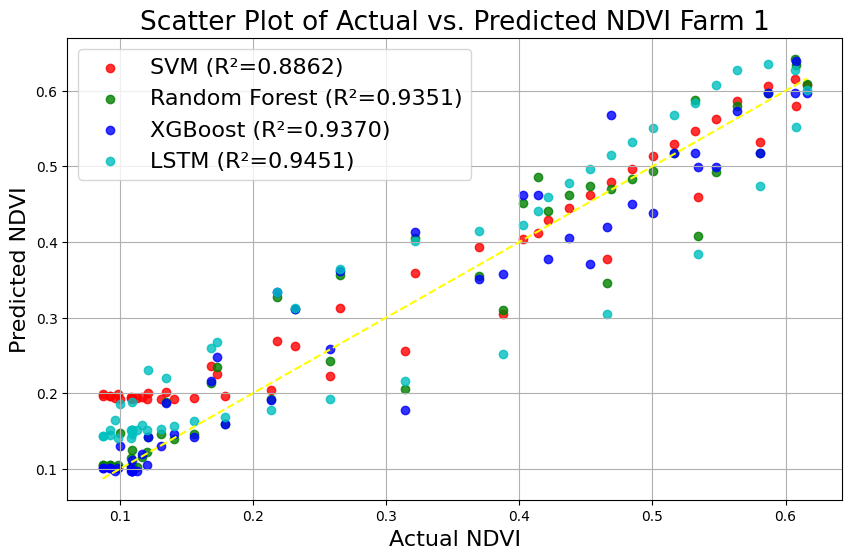

In [8]:
# Create a scatter plot to visualize the correlation between actual and predicted values for all models
plt.figure(figsize=(10, 6))
#plt.scatter(y_test, y_pred_svm, label=f"SVM (r={r2_svm:.4f})", alpha=0.8, color='r')
plt.scatter(y_test, y_pred_svm, label=f"SVM (R²={r2_svm:.4f})", alpha=0.8, color='r')

plt.scatter(y_test, y_pred_rf, label=f"Random Forest (R²={r2_rf:.4f})", alpha=0.8, color='g')
plt.scatter(y_test, y_pred_xgb, label=f"XGBoost (R²={r2_xgb:.4f})", alpha=0.8, color='b')
plt.scatter(y_test, y_pred_lstm, label=f"LSTM (R²={r2_lstm:.4f})", alpha=0.8, color='c')
#plt.scatter(y_test, y_pred_gru, label=f"GRU (r={r2_gru:.4f})", alpha=0.8, color='m')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='yellow', linestyle='--')
plt.xlabel("Actual NDVI",fontsize = 16)
plt.ylabel("Predicted NDVI",fontsize = 16)
plt.title("Scatter Plot of Actual vs. Predicted NDVI Farm 1",fontsize = 19)
plt.legend(prop={"size": 16})
plt.grid(True)
plt.show()


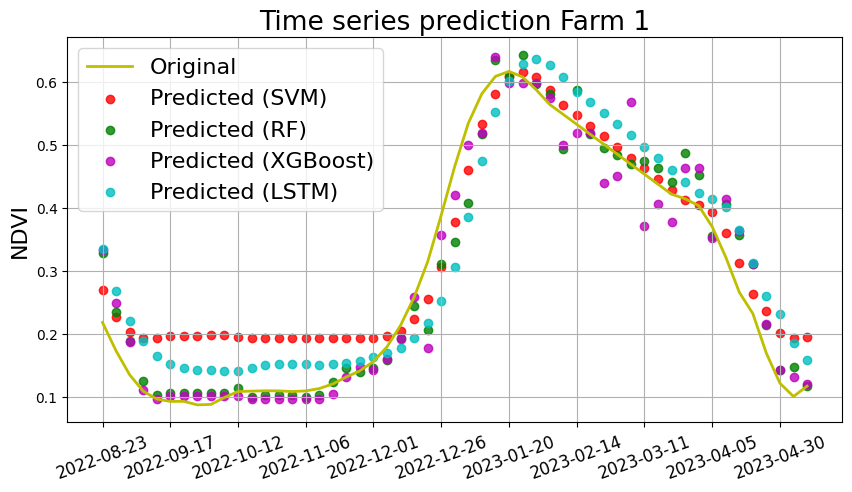

In [6]:
# Assuming you have y_test, test_dates, and y_pred_rf (Random Forest predictions), y_pred_svm (SVR predictions), y_pred_gru (GRU predictions), and y_pred_xgb (XGBoost predictions), and y_pred_lstm (LSTM predictions)

# Plot Testing Data with Original and Predicted values using scatter
fig, ax = plt.subplots(figsize=(10, 5))

# Plot original values (y_test)
ax.plot(y_test, linewidth=2, label='Original', color='y')

# Scatter plot for SVR predictions (y_pred_svm)
ax.scatter(range(len(y_pred_svm)), y_pred_svm, label='Predicted (SVM)', color='r', marker='o', alpha=0.8)
# Scatter plot for Random Forest predictions (y_pred_rf)
ax.scatter(range(len(y_pred_rf)), y_pred_rf, label='Predicted (RF)', color='g', marker='o', alpha=0.8)
# Scatter plot for GRU predictions (y_pred_gru)
#ax.scatter(range(len(y_pred_gru)), y_pred_gru, label='Predicted (GRU)', color='b', marker='o', alpha=0.8)
# Scatter plot for XGBoost predictions (y_pred_xgb)
ax.scatter(range(len(y_pred_xgb)), y_pred_xgb, label='Predicted (XGBoost)', color='m', marker='o', alpha=0.8)
# Scatter plot for LSTM predictions (y_pred_lstm)
ax.scatter(range(len(y_pred_lstm)), y_pred_lstm, label='Predicted (LSTM)', color='c', marker='o', alpha=0.8)

ax.set_xticks(range(0, len(test_dates.values), 5))
ax.set_xticklabels(test_dates.values[::5], rotation=20,fontsize = 12)

ax.set_title('Time series prediction Farm 1',fontsize = 19)
ax.set_ylabel('NDVI',fontsize = 16)
ax.legend(prop={"size": 16},loc="upper left")
ax.grid(True)
plt.show()

######
# plt.xlabel("Actual NDVI",fontsize = 16)
# plt.ylabel("Predicted NDVI",fontsize = 16)
# plt.title("Scatter Plot of Actual vs. Predicted NDVI Farm 1",fontsize = 19)
# plt.legend(prop={"size": 16})
